# HRC Price Prediction for Japan

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

## Correlation between HRC prices in China and Japan

In [190]:
# Read data of HRC price in China
df_CN = pd.read_csv('../data/processed/after_fillna.csv')
df_CN = df_CN[['Date', 'Month', 'HRC (FOB, $/t)']]

In [191]:
# Read data of HRC price in Japan
df_JP = pd.read_excel('../data/raw/Japan HRC FOB.xlsx')
df_JP.rename(columns={'Month': 'Month_JP'}, inplace=True)

In [192]:
# Merge data of the HRC prices in China and Japan
hrc_price_CN_JP = pd.concat([df_CN, df_JP], axis=1, ignore_index=False)
hrc_price_CN_JP

,Date,Month,"HRC (FOB, $/t)",Month_JP,Japan HRC FOB ($/t)
0,2006-01-01,Jan-06,388.0,2006-01-01,480
1,2006-02-01,Feb-06,388.0,2006-02-01,480
2,2006-03-01,Mar-06,449.0,2006-03-01,490
3,2006-04-01,Apr-06,478.0,2006-04-01,460
4,2006-05-01,May-06,505.0,2006-05-01,490
...,...,...,...,...,...
225,2024-10-01,Oct-24,497.0,2024-10-01,540
226,2024-11-01,Nov-24,485.0,2024-11-01,550
227,2024-12-01,Dec-24,473.0,2024-12-01,520
228,2025-01-01,Jan-25,461.0,2025-01-01,520


In [193]:
# Examine the data columns
hrc_price_CN_JP.columns

Index(['Date', 'Month', 'HRC (FOB, $/t)', 'Month_JP', 'Japan HRC FOB ($/t)'], dtype='object')

In [194]:
# Consolidate data column formats and drop the redundant column "Month" 
hrc_price_CN_JP.rename(columns={'HRC (FOB, $/t)': 'China HRC (FOB, $/t)',
                               'Japan HRC FOB ($/t)': 'Japan HRC (FOB, $/t)'}, inplace=True)
hrc_price_CN_JP['Date'] = hrc_price_CN_JP['Month_JP']
hrc_price_CN_JP.drop(['Month', 'Month_JP'], axis=1, inplace=True)
hrc_price_CN_JP.set_index('Date', inplace=True)
hrc_price_CN_JP

,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
Date,,
2006-01-01,388.0,480
2006-02-01,388.0,480
2006-03-01,449.0,490
2006-04-01,478.0,460
2006-05-01,505.0,490
...,...,...
2024-10-01,497.0,540
2024-11-01,485.0,550
2024-12-01,473.0,520


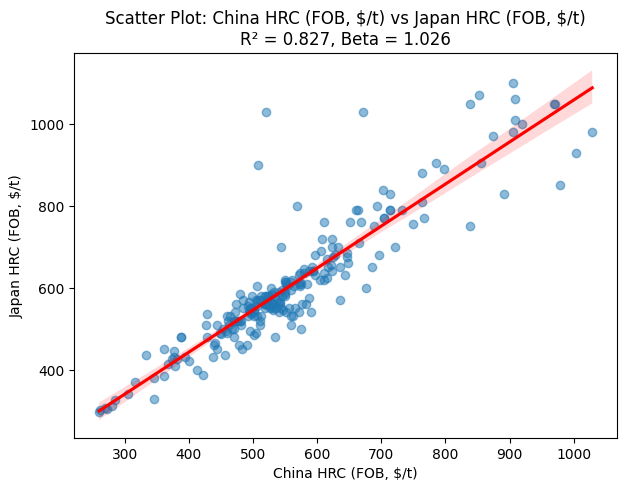

In [195]:
# Examine and visualise the correlation between HRC prices in China and Japan

x_col = 'China HRC (FOB, $/t)'
y_col = 'Japan HRC (FOB, $/t)'

# Drop NaN values for the current variable
temp_df = hrc_price_CN_JP[[x_col, y_col]].dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(temp_df[x_col], temp_df[y_col])
r_squared = r_value**2  # R² value

# Create plot
plt.figure(figsize=(7, 5))
sns.regplot(x=temp_df[x_col], y=temp_df[y_col], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

# Labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
x_col_name = x_col.replace("$", r"\$")
y_col_name = y_col.replace("$", r"\$")
plt.title(f"Scatter Plot: {x_col_name} vs {y_col_name}\nR² = {r_squared:.3f}, Beta = {slope:.3f}")

# Show plot
plt.show()

## Prediction of Japan HRC Prices using China's Prices

## Model Training

### Linear Regression

In [197]:
# Prepare X and y columns
X = temp_df[["China HRC (FOB, $/t)"]]
y = temp_df["Japan HRC (FOB, $/t)"]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [198]:
# Model fitting
model_linreg = LinearRegression()
model_linreg_fitted = model_linreg.fit(X_train, y_train)

In [199]:
# Model predictions
y_pred_linreg = model_linreg_fitted.predict(X_test)

In [200]:
# Get feature names and coefficients
feature_names_linreg = ["Intercept"] + list(X.columns)
intercept_linreg = model_linreg_fitted.intercept_
coef_linreg = model_linreg_fitted.coef_

coefficients_linreg = [intercept_linreg] + list(coef_linreg)

# Display results
pd.DataFrame({"Feature": feature_names_linreg, "Coefficient": coefficients_linreg})


,Feature,Coefficient
0,Intercept,20.806508
1,"China HRC (FOB, $/t)",1.049746


In [201]:
# Error metrics
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
r2_linreg = r2_score(y_test, y_pred_linreg)

print("Error metrics of linear regression model\n")
print('Mean Absolute Error: ', mae_linreg)
print('Mean Squared Error: ', mse_linreg)
print('Root Mean Squared Error: ', rmse_linreg)
print('R-squared: ', r2_linreg)

Error metrics of linear regression model

Mean Absolute Error:  30.76859140133485
Mean Squared Error:  1829.6178131363527
Root Mean Squared Error:  42.77403199531642
R-squared:  0.9215976972213965


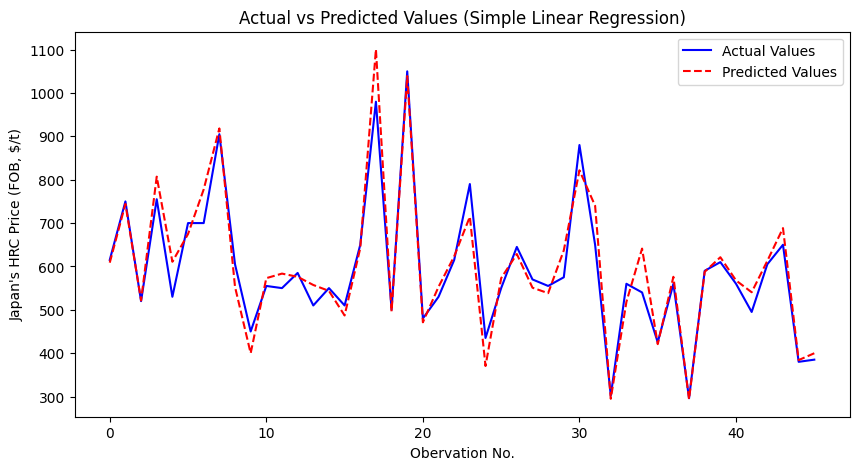

In [202]:
# Plot actual vs predicted Japan HRC Prices
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred_linreg)), y_pred_linreg, label="Predicted Values", color="red", linestyle="dashed")

plt.xlabel("Obervation No.")
plt.ylabel("Japan's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Simple Linear Regression)")
plt.legend()
plt.show()

### Polynomial Regression

In [203]:
# Working with second degree polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)
poly

PolynomialFeatures(include_bias=False)

In [204]:
# Transform BOTH training and testing data
X_train_poly = poly.fit_transform(X_train)  # Fit and transform for training
X_test_poly = poly.transform(X_test)        # Only transform for testing

# Train the model using transformed training data
model_poly = LinearRegression()
model_poly_fitted = model_poly.fit(X_train_poly, y_train)

# Predict using the transformed test data
y_pred_poly = model_poly_fitted.predict(X_test_poly)

In [205]:
# Get feature names and coefficients
feature_names_poly = ["Intercept"] + list(poly.get_feature_names_out(input_features=X.columns))
intercept_poly = model_poly_fitted.intercept_
coef_poly = model_poly_fitted.coef_

coefficients_poly = [intercept_poly] + list(coef_poly)

# Display results
pd.DataFrame({"Feature": feature_names_poly, "Coefficient": coefficients_poly})

,Feature,Coefficient
0,Intercept,-21.265600
1,"China HRC (FOB, $/t)",1.192575
2,"China HRC (FOB, $/t)^2",-0.000114


In [206]:
# Error metrics
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print("Error metrics of polynomial regression model (degree = 2)\n")
print('Mean Absolute Error: ', mae_poly)
print('Mean Squared Error: ', mse_poly)
print('Root Mean Squared Error: ', rmse_poly)
print('R-squared: ', r2_poly)

Error metrics of polynomial regression model (degree = 2)

Mean Absolute Error:  31.64571987704406
Mean Squared Error:  1843.6559315433024
Root Mean Squared Error:  42.93781470386333
R-squared:  0.9209961394524016


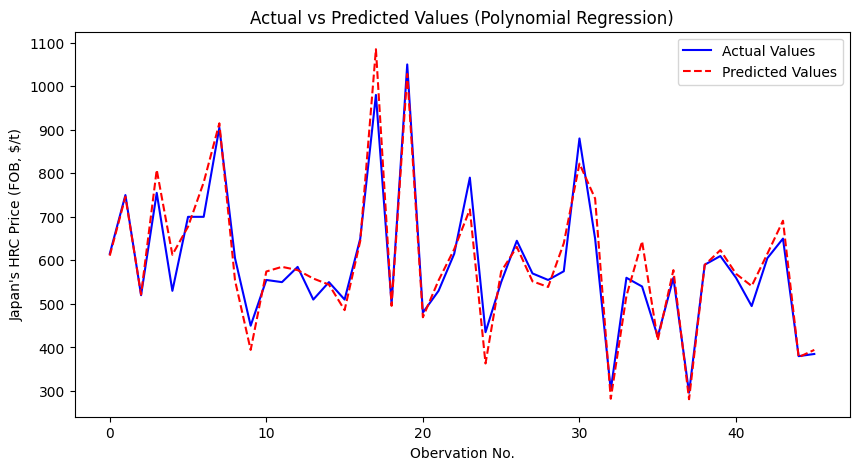

In [207]:
# Assuming y_test and y_pred are 1D arrays
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred_poly)), y_pred_poly, label="Predicted Values", color="red", linestyle="dashed")

plt.xlabel("Obervation No.")
plt.ylabel("Japan's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Polynomial Regression)")
plt.legend()
plt.show()

In [208]:
# Compare the two models
comparison_stats = {
    'Metric': ['Equation', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared'],
    'Linear Regression': [f"JP Price = {coef_linreg[0]}*CN Price + {intercept_linreg}", mae_linreg, mse_linreg, rmse_linreg, r2_linreg],
    'Polynomial Regression with Degree=2': [f"JP Price = {coef_poly[1]}*(CN Price)^2 + {coef_poly[0]}*CN Price {intercept_poly}", mae_poly, mse_poly, rmse_poly, r2_poly]
}

pd.set_option('display.max_colwidth', None) # to prevent truncation of output
pd.DataFrame(comparison_stats)

,Metric,Linear Regression,Polynomial Regression with Degree=2
0,Equation,JP Price = 1.0497461121938285*CN Price + 20.80650829721958,JP Price = -0.00011421654157866243*(CN Price)^2 + 1.1925750780760398*CN Price -21.265600262335397
1,Mean Absolute Error,30.768591,31.64572
2,Mean Squared Error,1829.617813,1843.655932
3,Root Mean Squared Error,42.774032,42.937815
4,R-squared,0.921598,0.920996


## Prediction of Japan's HRC Price

### Data Preparation

In [209]:
# Read predicted data for HRC price in China
hrc_CN_forecast = pd.read_csv('../data/final/multireg_forecast.csv')
hrc_CN_forecast.rename(columns={'HRC (FOB, $/t)_f': 'China HRC (FOB, $/t)'}, inplace=True)

date_index = hrc_CN_forecast['Date']
hrc_CN_forecast.drop(['Date'], axis=1, inplace=True)
hrc_CN_forecast.set_index(pd.DatetimeIndex(date_index), inplace=True)

hrc_CN_forecast

,"China HRC (FOB, $/t)"
Date,
2024-10-01,497.000000
2024-11-01,470.754576
2024-12-01,487.244364
2025-01-01,506.528922
2025-02-01,488.641676
2025-03-01,456.712881
2025-04-01,470.805399
2025-05-01,470.274494
2025-06-01,461.629705


In [210]:
# Dropping forecasted values before Feb 2025 as the actual data is available
hrc_CN_forecast = hrc_CN_forecast.loc[hrc_CN_forecast.index >= '2025-02-01']

In [211]:
# Re-examine the available data about HRC prices in China and Japan
hrc_price_CN_JP

,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
Date,,
2006-01-01,388.0,480
2006-02-01,388.0,480
2006-03-01,449.0,490
2006-04-01,478.0,460
2006-05-01,505.0,490
...,...,...
2024-10-01,497.0,540
2024-11-01,485.0,550
2024-12-01,473.0,520


In [212]:
# Check for duplicates in the merged data
hrc_price_CN_JP = pd.concat([hrc_price_CN_JP, hrc_CN_forecast], axis=0, ignore_index=False)
duplicated_index = hrc_price_CN_JP[hrc_price_CN_JP.index.duplicated() == True].index.values
hrc_price_CN_JP.loc[hrc_price_CN_JP.index.isin(duplicated_index)]

,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
Date,,
2025-02-01,NaN,535.0
2025-02-01,488.641676,NaN


In [213]:
# Drop duplicates - fill in NA values
hrc_price_CN_JP['China HRC (FOB, $/t)'] = hrc_price_CN_JP['China HRC (FOB, $/t)'].bfill() # fill with succeeding value
hrc_price_CN_JP['Japan HRC (FOB, $/t)'] = hrc_price_CN_JP['Japan HRC (FOB, $/t)'].ffill() # fill with preceeding value
hrc_price_CN_JP.loc[hrc_price_CN_JP.index.isin(duplicated_index)]

,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
Date,,
2025-02-01,488.641676,535.0
2025-02-01,488.641676,535.0


In [217]:
# Drop duplicates in the merged data
hrc_price_CN_JP.drop_duplicates(inplace=True)

# Dropping values after Feb 2025 (which will be forecasted)
hrc_price_CN_JP['Japan HRC (FOB, $/t)'] = hrc_price_CN_JP['Japan HRC (FOB, $/t)'].loc[hrc_price_CN_JP.index <= '2025-02-01']

# Export the data into a csv file
# The file will contain the China's HRC price from Jan 2006 to Mar 2025 (both actual and predicted),
# and the Japan's HRC price from Jan 2006 to Jan 2006 to Feb 2025 (actual only)
hrc_price_CN_JP.to_csv('../data/final/hrc_price_CN_JP.csv', index=True)

In [221]:
# Prepare China's HRC price for the period to be forecasted
x_CN = hrc_price_CN_JP[['China HRC (FOB, $/t)']].loc[hrc_price_CN_JP.index > '2025-02-01']
x_CN

,"China HRC (FOB, $/t)"
Date,
2025-03-01,456.712881
2025-04-01,470.805399
2025-05-01,470.274494
2025-06-01,461.629705
2025-07-01,454.656506
2025-08-01,437.136414
2025-09-01,431.183603
2025-10-01,424.602300
2025-11-01,399.493432


In [235]:
# Obtain y forecast (Japan's HRC price)
x_CN_poly_trans = poly.transform(x_CN) # transform China's HRC price to achieve polynomial features with degree=2
y_JP_forecast = model_poly_fitted.predict(x_CN_poly_trans)

#adding 10/1/2024 value to have a smooth line when plotting
y_JP_insert = hrc_price_CN_JP['Japan HRC (FOB, $/t)'].loc['2025-02-01']
y_JP_forecast_new = np.insert(y_JP_forecast, 0, y_JP_insert)

fc_period = pd.date_range(start='2025-02-01', end='2026-03-01', freq='MS')
df_forecast_JP = pd.DataFrame(y_JP_forecast_new, index=fc_period, columns=['Japan HRC (FOB, $/t)_f'])

df_forecast_JP

,"Japan HRC (FOB, $/t)_f"
2025-02-01,535.000000
2025-03-01,499.574753
2025-04-01,514.888207
2025-05-01,514.312128
2025-06-01,504.922710
2025-07-01,497.336426
2025-08-01,478.226954
2025-09-01,471.718159
2025-10-01,464.512750
2025-11-01,436.931921


In [236]:
# Export forecasted HRC price in China to a csv file
df_forecast_JP[1:].to_csv('../data/final/JP_forecast.csv', index=True)

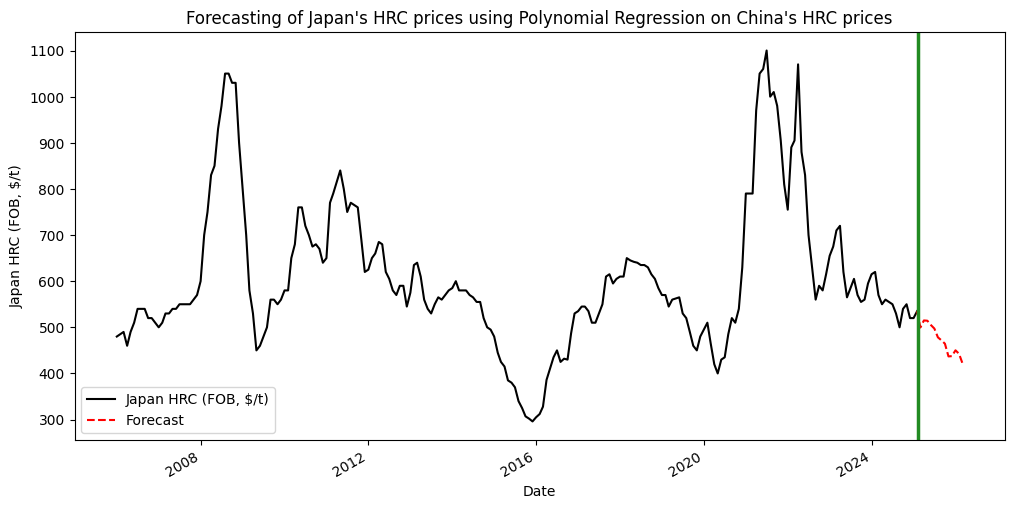

In [243]:
# Plot forecast
fig, ax = plt.subplots(figsize=(12, 6))

hrc_price_CN_JP['Japan HRC (FOB, $/t)'].plot(color='k')
df_forecast_JP['Japan HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("Forecasting of Japan's HRC prices using Polynomial Regression on China's HRC prices")
plt.ylabel("Japan HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2025-02-10', linewidth = 2.5, color = 'forestgreen', linestyle = 'solid')
ax.legend()

In [ ]:
# The following codes may be used for building the dashboard
'''
hrc_price_CN_JP = pd.read_csv('../data/final/hrc_price_CN_JP.csv', index=False)
hrc_price_CN_JP.dropna(inplace=True)

# Prepare X and y columns
X = hrc_price_CN_JP["China HRC (FOB, $/t)"]
y = hrc_price_CN_JP["Japan HRC (FOB, $/t)"]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Working with second degree polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)

# Transform training data for model testing
X_train_poly = poly.fit_transform(X_train)  # Fit and transform for training

# Train the model using transformed training data
model_poly = LinearRegression()
model_poly_fitted = model_poly.fit(X_train_poly, y_train)

# Use the trained model for prediction
# 1. Obtain x (China's HRC price with polynomial features)
x_CN = hrc_price_CN_JP[['China HRC (FOB, $/t)']].loc[hrc_price_CN_JP.index > '2025-02-01']
x_CN_poly_trans = poly.transform(x_CN) # transform China's HRC price to achieve polinomial features with degree=2

# 2. Obtain y forecast (Japan's HRC price)
y_JP_forecast = model_poly_fitted.predict(x_CN_poly_trans)
'''